# Search for available data

Before downloading satellite data it is important to know exactly which data is available and what kind of properties it has. Sentinel Hub offers multiple services to search collections of data:

- [Catalog API](#Sentinel-Hub-Catalog-API)
- [Web Feature Service](#Web-Feature-Service-(WFS))
- [Opensearch service](#Sentinel-Hub-Opensearch)

In this example tutorial we will show how to use each of the services.

Some general imports:

In [1]:
%matplotlib inline

import datetime as dt

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import CRS, BBox, DataCollection, SHConfig

## Sentinel Hub Catalog API

Catalog API is the main service with the most configurable search options. It supports searches over all available data collections and provides the most information about each item in a collection. The implementation is based on [STAC REST API specifications](https://stacspec.org/).

More information about the service is available in:

- [Documentation](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Catalog.html)
- [API definition](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/ApiReference.html)

### Prerequisites

Copernicus Data Space Ecosystem users must configure according to [Copernicus Data Space Ecosystem Configuration](https://sentinelhub-py.readthedocs.io/en/latest/configure.html#copernicus-data-space-ecosystem-configuration).

In [2]:
config = SHConfig()

if config.sh_client_id == "" or config.sh_client_secret == "":
    print("Warning! To use Sentinel Hub Catalog API, please provide the credentials (client ID and client secret).")

### Available data collections

In the first, step let's initialize a `SentinelHubCatalog` class and check basic service info:

In [3]:
from sentinelhub import SentinelHubCatalog

catalog = SentinelHubCatalog(config=config)

catalog.get_info()

{'type': 'Catalog',
 'stac_version': '1.0.0',
 'id': 'sentinel-hub',
 'title': 'Sentinel Hub STAC catalog',
 'description': 'STAC v1.0.0 implementation by Sentinel Hub',
 'conformsTo': ['http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson',
  'https://api.stacspec.org/v1.0.0/core',
  'https://api.stacspec.org/v1.0.0/collections',
  'https://api.stacspec.org/v1.0.0/ogcapi-features',
  'https://api.stacspec.org/v1.0.0/ogcapi-features#fields',
  'https://api.stacspec.org/v1.0.0/ogcapi-features#context',
  'https://api.stacspec.org/v1.0.0/ogcapi-features#filter',
  'https://api.stacspec.org/v1.0.0/item-search',
  'https://api.stacspec.org/v1.0.0/item-search#fields',
  'https://api.stacspec.org/v1.0.0/item-search#context',
  'https://api.stacspec.org/v1.0.0/item-search#filter',
  'http://www.opengis.net/spec/ogcapi-features-3/1.0/conf/filter',
  'http

Each data collection has its own catalog collection. The default collections are already listed in the info response. Information about all available collections, including user-defined [BYOC](https://docs.sentinel-hub.com/api/latest/data/byoc/) and [batch](https://docs.sentinel-hub.com/api/latest/api/batch/) collections, can be obtained with the next example.

The following code will obtain information about all collections but then filter out BYOC and batch collections:

In [4]:
collections = catalog.get_collections()

collections = [collection for collection in collections if not collection["id"].startswith(("byoc", "batch"))]

collections

[{'stac_version': '1.0.0',
  'stac_extensions': ['https://stac-extensions.github.io/scientific/v1.0.0/schema.json',
   'https://stac-extensions.github.io/eo/v1.0.0/schema.json'],
  'type': 'Collection',
  'id': 'sentinel-2-l1c',
  'title': 'Sentinel 2 L1C',
  'description': 'Sentinel 2 imagery processed to level 1C',
  'sci:citation': 'Modified Copernicus Sentinel data [Year]/Sentinel Hub',
  'license': 'proprietary',
  'providers': [{'name': 'ESA',
    'roles': ['producer'],
    'url': 'https://esa.int/'},
   {'name': 'CDSE',
    'roles': ['processor', 'host'],
    'url': 'https://dataspace.copernicus.eu/'},
   {'name': 'Sinergise',
    'roles': ['processor'],
    'url': 'https://www.sinergise.com/'}],
  'extent': {'spatial': {'bbox': [[-180.0, -56.0, 180.0, 83.0]]},
   'temporal': {'interval': [['2015-11-01T00:00:00Z', None]]}},
  'summaries': {'platform': ['sentinel-2a', 'sentinel-2b'],
   'instrument': ['msi'],
   'constellation': ['sentinel-2'],
   'gsd': [10],
   'eo:cloud_cover'

Information about a single collection can also be obtained with the following method:

In [5]:
catalog.get_collection(DataCollection.SENTINEL1_EW.define_from("S1GRD_EW", service_url=config.sh_base_url))

{'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/scientific/v1.0.0/schema.json',
  'https://stac-extensions.github.io/sat/v1.0.0/schema.json',
  'https://stac-extensions.github.io/sar/v1.0.0/schema.json',
  'https://docs.sentinel-hub.com/api/latest/stac/s1/v1.0.0/schema.json'],
 'type': 'Collection',
 'id': 'sentinel-1-grd',
 'title': 'Sentinel 1 GRD',
 'description': 'Sentinel 1 Ground Range Detected Imagery',
 'sci:citation': 'Modified Copernicus Sentinel data [Year]/Sentinel Hub',
 'license': 'proprietary',
 'providers': [],
 'extent': {'spatial': {'bbox': [[-180.0, -85.0, 180.0, 85.0]]},
  'temporal': {'interval': [['2014-10-03T00:00:00Z', None]]}},
 'summaries': {'platform': ['sentinel-1a', 'sentinel-1b'],
  'instrument': ['c-sar'],
  'constellation': ['sentinel-1'],
  'sat:orbit_state': ['ascending', 'descending'],
  'sar:instrument_mode': ['SM', 'IW', 'EW', 'WV'],
  'sar:frequency_band': ['C'],
  'sar:center_frequency': [5.405],
  'sar:product_ty

### Search features in catalog collections

Once we have successfully initialized a catalog object we can search for features inside a specific collection. If we have an ID of a satellite tile we can search for its information like this:

In [8]:
catalog.get_feature(
    DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
    "S2A_MSIL2A_20210125T073201_N0500_R049_T39TWK_20230528T024029.SAFE",
)

{'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json',
  'https://stac-extensions.github.io/projection/v1.0.0/schema.json'],
 'id': 'S2A_MSIL2A_20210125T073201_N0500_R049_T39TWK_20230528T024029.SAFE',
 'type': 'Feature',
 'geometry': {'type': 'MultiPolygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:OGC::CRS84'}},
  'coordinates': [[[[50.99975828238186, 45.15382824779532],
     [52.39639823709577, 45.14529082814174],
     [52.37288170686682, 44.15712570690993],
     [50.99976235468337, 44.16537549736596],
     [50.99975828238186, 45.15382824779532]]]]},
 'bbox': [50.99975828238186,
  44.15712570690993,
  52.39639823709577,
  45.15382824779532],
 'properties': {'datetime': '2021-01-25T07:37:20.296Z',
  'platform': 'sentinel-2a',
  'instruments': ['msi'],
  'constellation': 'sentinel-2',
  'gsd': 10,
  'eo:cloud_cover': 1.18,
  'proj:epsg': 32639,
  'proj:bbox': [499980.0, 4890240.0, 609780.0, 5000040.0],
  'pr

For any more advanced search we can use `SentinelHubCatalog.search` method. The method always requires a data collection, time interval and a bounding box or a geometry. Additionally, we can define various STAC-based query filters which are described in [documentation](https://docs.sentinel-hub.com/api/latest/api/catalog/) and [API definition](https://docs.sentinel-hub.com/api/latest/reference/#operation/postSearchSTAC).

In our case, we will filter all satellite tiles with more than `5%` cloud coverage. To reduce the size of downloaded responses we will also filter fields that will be returned in the response.

In [9]:
caspian_sea_bbox = BBox((49.9604, 44.7176, 51.0481, 45.2324), crs=CRS.WGS84)
time_interval = "2020-12-10", "2021-02-01"

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=caspian_sea_bbox,
    time=time_interval,
    filter="eo:cloud_cover < 5",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

results

Total number of results: 12


[{'id': 'S2A_MSIL2A_20210125T073201_N0500_R049_T39TWK_20230528T024029.SAFE',
  'properties': {'datetime': '2021-01-25T07:37:20.296Z',
   'eo:cloud_cover': 1.18}},
 {'id': 'S2A_MSIL2A_20210125T073201_N0500_R049_T39TVL_20230528T024029.SAFE',
  'properties': {'datetime': '2021-01-25T07:37:09.425Z',
   'eo:cloud_cover': 4.0}},
 {'id': 'S2A_MSIL2A_20210125T073201_N0500_R049_T39TWL_20230528T024029.SAFE',
  'properties': {'datetime': '2021-01-25T07:37:05.835Z',
   'eo:cloud_cover': 0.43}},
 {'id': 'S2A_MSIL2A_20210105T073311_N0500_R049_T39TWK_20230404T141905.SAFE',
  'properties': {'datetime': '2021-01-05T07:37:20.216Z',
   'eo:cloud_cover': 2.56}},
 {'id': 'S2A_MSIL2A_20201226T073321_N0500_R049_T39TWK_20230414T073429.SAFE',
  'properties': {'datetime': '2020-12-26T07:37:19.181Z',
   'eo:cloud_cover': 2.61}},
 {'id': 'S2A_MSIL2A_20201226T073321_N0500_R049_T39TVL_20230414T073429.SAFE',
  'properties': {'datetime': '2020-12-26T07:37:08.298Z',
   'eo:cloud_cover': 3.06}},
 {'id': 'S2A_MSIL2A_202

### Combine Catalog API with Process API

With Catalog API we were able to get information all satellites tiles for a given bounding box and time interval. Let's see how we can use this information with [Process API](./process_request.ipynb) to download data for all acquisitions.

We can see that many timestamps differ only for a few seconds. That is because they are from tiles in the same orbit acquisition. Because of that, we want to join them together in a single timestamp.

In [10]:
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

time_difference = dt.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

unique_acquisitions

[datetime.datetime(2020, 12, 11, 7, 37, 2, 436000, tzinfo=tzutc()),
 datetime.datetime(2020, 12, 16, 7, 37, 2, 951000, tzinfo=tzutc()),
 datetime.datetime(2020, 12, 26, 7, 37, 4, 725000, tzinfo=tzutc()),
 datetime.datetime(2021, 1, 5, 7, 37, 20, 216000, tzinfo=tzutc()),
 datetime.datetime(2021, 1, 25, 7, 37, 5, 835000, tzinfo=tzutc())]

Next, we create a Process API request for each acquisition:

In [11]:
false_color_evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B03", "B04", "B08"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B08, sample.B04, sample.B03];
    }
"""


process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=false_color_evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=caspian_sea_bbox,
        size=bbox_to_dimensions(caspian_sea_bbox, 100),
        config=config,
    )
    process_requests.append(request)

In order to efficiently download data for all requests in parallel, we extract download information and pass it to a download client.

In [12]:
%%time

client = SentinelHubDownloadClient(config=config)

download_requests = [request.download_list[0] for request in process_requests]

data = client.download(download_requests)

data[0].shape

CPU times: user 221 ms, sys: 36.3 ms, total: 258 ms
Wall time: 3 s


(567, 861, 3)

Downloaded images nicely show how the ice cover has been changing over Caspian Sea during winter.

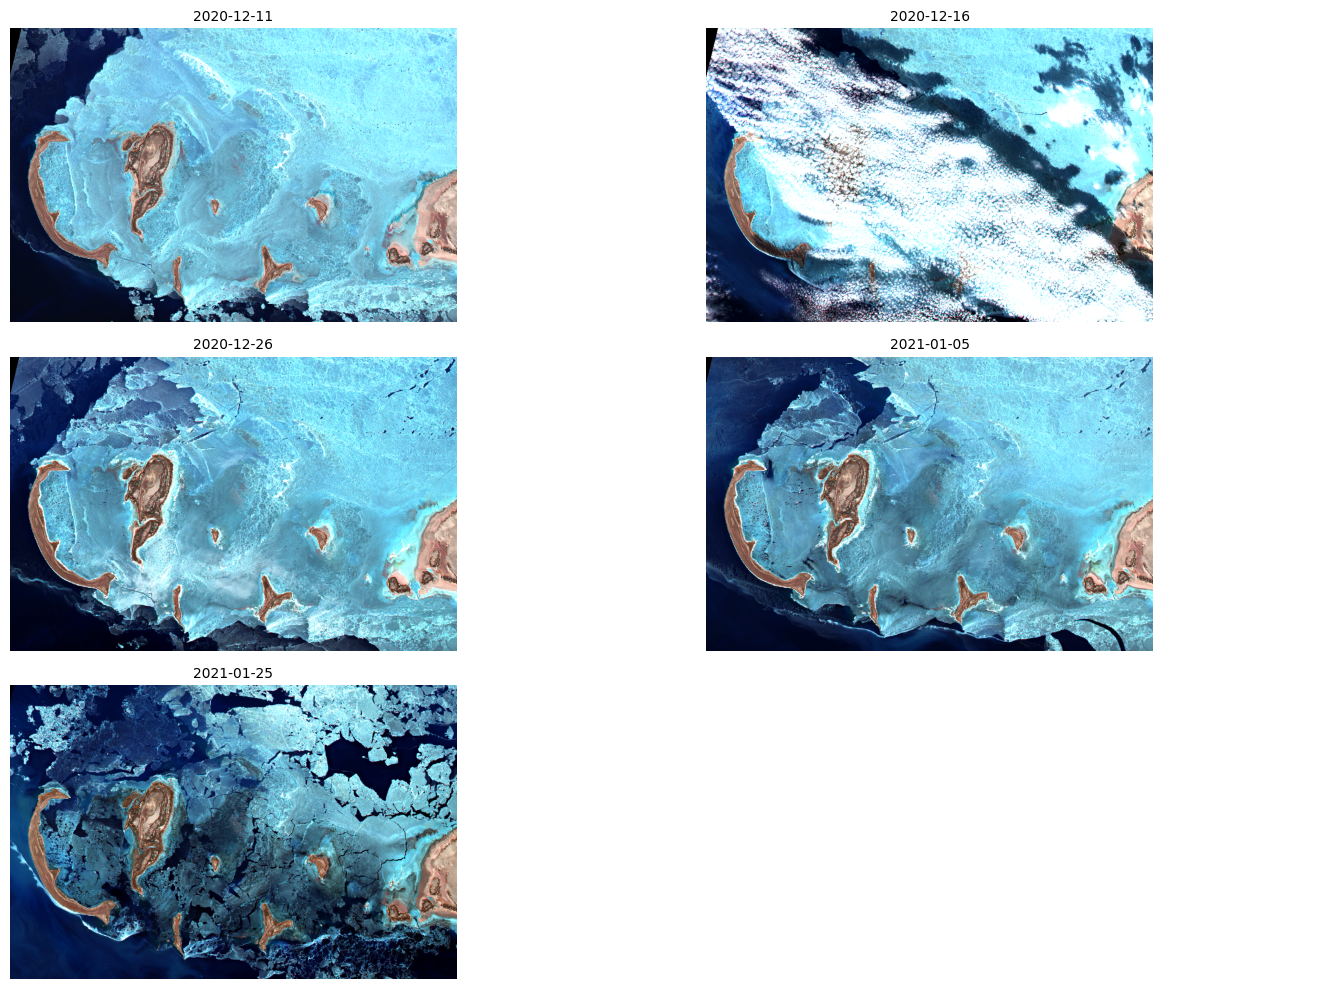

In [14]:
ncols, nrows = 2, 3

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(15, 10), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):
    ax = axis[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(timestamp.date().isoformat(), fontsize=10)

plt.tight_layout()

## Web Feature Service (WFS)

This is an OGC-based service that allows searching with a bounding box and time interval. Instead of OAuth credentials, it requires an instance ID of a configuration created in [Sentinel Hub Dashboard](https://apps.sentinel-hub.com/dashboard/#/configurations). For each data collection that you search you have to make sure that you have at least one layer with that data collection defined in a configuration that you are using.

More information can be found in [WFS service documentation](https://www.sentinel-hub.com/develop/api/ogc/standard-parameters/wfs/).

In [16]:
from sentinelhub import WebFeatureService

# In case you put the credentials into the configuration file you can leave this unchanged
INSTANCE_ID = ""

config = SHConfig()
if INSTANCE_ID:
    config.instance_id = INSTANCE_ID

Let's search with the same parameters used in the Catalog API example above. We obtain the same number of results but with a bit different types of information in properties.

In [17]:
caspian_sea_bbox = BBox((49.9604, 44.7176, 51.0481, 45.2324), crs=CRS.WGS84)
time_interval = "2020-12-10", "2021-02-01"

wfs_iterator = WebFeatureService(
    caspian_sea_bbox,
    time_interval,
    data_collection=DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
    maxcc=0.05,
    config=config,
)


results = list(wfs_iterator)
print("Total number of results:", len(results))

results[0]

Total number of results: 12


{'type': 'Feature',
 'geometry': {'type': 'MultiPolygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}},
  'coordinates': [[[[50.999758282381855, 45.15382824914294],
     [52.396398237151104, 45.14529082948613],
     [52.37288170691262, 44.157125708042365],
     [50.99976235468336, 44.16537549850127],
     [50.999758282381855, 45.15382824914294]]]]},
 'properties': {'date': '2021-01-25',
  'time': '07:37:20.296',
  'path': 'creo://EODATA/Sentinel-2/MSI/L2A_N0500/2021/01/25/S2A_MSIL2A_20210125T073201_N0500_R049_T39TWK_20230528T024029.SAFE/GRANULE/L2A_T39TWK_A029218_20210125T073204/IMG_DATA/RRESOLUTION/T39TWK_20210125T073201_TILEBAND_RESOLUTION',
  'crs': 'EPSG:32639',
  'mbr': '499980,4890240 609780,5000040',
  'cloudCoverPercentage': 1.18}}